In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict

class PlotHelper():
    def __init__(self):
        self.reset()

    def reset(self):
        self._f = None
        self._ax = None
        self.kvals = defaultdict(list)

    def add(self, **kval):
        for k, v in kval.items():
            self.kvals[k].append(v)

    @property
    def fig(self):
        if self._f is None:
            self.new()
        return self._f

    @property
    def ax(self):
        if self._ax is None:
            self.new()
        return self._ax

    def new(self):
        self._f, self._ax = plt.subplots(1,1)
        plt.ion()
        self.fig.show()

    def show(self):
        names = []
        self.ax.clear()
        for k, v in self.kvals.items():
            names.append(k)
            self.ax.plot(v)
        self.ax.legend(names)
        self.fig.canvas.draw()

In [21]:
def sample_balanced_subset(dataset, n_per_class):
    classes = dataset.targets.unique()
    indices = [(dataset.targets == c).nonzero(as_tuple=False) [:n_per_class] for c in classes]
    indices = torch.stack(indices).flatten()
    return torch.utils.data.Subset(dataset, indices)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 20)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x.reshape(10,2)


def train(args, model, device, train_loader, optimizer, epoch, cons=None, plot_loss=None):
    
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        output = output.reshape(10,10)
        
        loss = F.cross_entropy(output[:1], target)
        closs = cons(output) if cons else torch.tensor(0).to(device)
        
        loss += closs
            
        loss.backward()
        optimizer.step()
        
        # Logging
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        
        for data, target in test_loader:
            
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.reshape(10,10)
            # sum up batch loss
            test_loss += F.cross_entropy(output[:1], target, reduction='sum').item()
            
            # get the index of the max log-probability
            pred = output[:1].argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [23]:
import sys
sys.path.append("..")

from pylon.constraint import constraint
from pylon.brute_force_solver import SatisfactionBruteForceSolver
from pylon.sampling_solver import SamplingSolver, WeightedSamplingSolver

def only_one(x):
    return x.sum(dim=-1) == 1

class Args:
    batch_size = 1
    test_batch_size = 1000
    epochs = 1
    lr = 1.0
    gamma = 0.7
    seed = 1
    log_interval = 10
    use_cuda = False
    n_per_class = 100
    
# Plotting
plot_loss = PlotHelper()
    
args = Args()
torch.manual_seed(args.seed)

device = torch.device("cuda" if args.use_cuda else "cpu")

kwargs = {'batch_size': args.batch_size}
if args.use_cuda:
    kwargs.update({'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True},
                 )

# Prepare dataset transformations
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Load train and test splits
train_split = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
test_split = datasets.MNIST('../data', train=False,
                   transform=transform)

# Sample a balanced subset of the train set
train_split = sample_balanced_subset(train_split, args.n_per_class)

# Create train, validation and test data loaders
train_loader = torch.utils.data.DataLoader(train_split,**kwargs)
test_loader  = torch.utils.data.DataLoader(test_split, **kwargs)

# Constraint to be applied on unlabeled data
only_one_constraint = constraint(only_one, SatisfactionBruteForceSolver())
# only_one_constraint = constraint(only_one, WeightedSamplingSolver(num_samples=200))
# only_one_constraint = constraint(only_one, SamplingSolver(num_samples=200))

# Move model to correct device
model = Net().to(device)

# Set up optimizer
# optimizer = optim.SGD(model.parameters(), lr=args.lr)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

In [24]:
for X, y in train_loader:
    break

  0%|          | 0/1 [00:00<?, ?it/s]/Users/hanliying/Documents/UCLA/Research/Neurosym_proj/pylon-master/examples/../pylon/brute_force_solver.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.stack([torch.tensor(data=self.cond(*sample), dtype=torch.bool) if kwargs == {}
100%|██████████| 1/1 [00:00<00:00,  6.33it/s]
/var/folders/kk/zn19ckhn56s6kwjrwp70f8kc0000gp/T/ipykernel_2625/1932012216.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


tensor([[[-1.0397, -0.6701],
         [-0.3310,  0.0271],
         [ 0.2637, -1.0437],
         [ 0.5965, -1.7663],
         [ 0.0142, -0.1075],
         [ 0.3138,  0.4218],
         [ 0.8880, -1.2280],
         [ 1.1796, -0.5855],
         [ 0.8292, -0.6835],
         [ 0.8635,  0.1001]]], grad_fn=<UnsqueezeBackward0>)
tensor([[[-1.0397, -0.6701],
         [-0.3310,  0.0271],
         [ 0.2637, -1.0437],
         [ 0.5965, -1.7663],
         [ 0.0142, -0.1075],
         [ 0.3138,  0.4218],
         [ 0.8880, -1.2280],
         [ 1.1796, -0.5855],
         [ 0.8292, -0.6835],
         [ 0.8635,  0.1001]]], grad_fn=<UnsqueezeBackward0>)


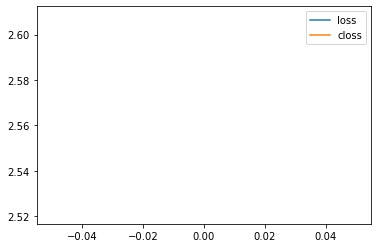

In [28]:
from tqdm import tqdm

# # Plotting
plot_loss = PlotHelper()
#range 500
for i in tqdm(range(1)):
    
    optimizer.zero_grad()
        
    output = model(X)
    loss = F.cross_entropy(output[:,1].reshape(1,10), y)
    closs = only_one_constraint(output.unsqueeze(0)) # Expects tensors of shape: batch_size x ... x num_classes
    
    total_loss = loss + closs
    
    plot_loss.add(loss=loss.data, closs=closs.data, )
    total_loss.backward()
    optimizer.step()
    
plot_loss.show()

In [26]:
torch.argmax(torch.softmax(model(X), dim=-1), dim=-1)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [27]:
output.shape

torch.Size([10, 2])